# Exploring Gym Membership Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

** Load Data **

In [2]:
dict_file = 'names/name_dict.pckl'
with open(dict_file, 'rb') as fp:
    name_dict = pickle.load(fp)

In [3]:
xls = pd.ExcelFile('data/Full_Member_Data.xlsx')
inactive = pd.read_excel(xls, 'Sheet2')

** Fill in missing genders **

In [4]:
inactive['SEX'].value_counts()

F    6895
M    6655
U     243
Name: SEX, dtype: int64

In [5]:
def gender_lookup(full_name, sex):
    sex_dict = {'male':'M','female':'F'}
    if sex == 'U':
        name = full_name.split()[0]
        try:
            gender = name_dict[name.upper()]
            return sex_dict[gender]
        except:
            return 'U'
    else:
        return sex

In [6]:
inactive['SEX'] = inactive.apply(lambda row: gender_lookup(
                                row['PROPER_NAME'], 
                                row['SEX']), axis=1)

In [7]:
inactive['SEX'].value_counts()

F    7016
M    6756
U      21
Name: SEX, dtype: int64

In [8]:
inactive.columns

Index(['CLUB_ID', 'MEMB_NUM', 'PROPER_NAME', 'CONTRACT_DATE',
       'EXPIRATION_DATE', 'AMOUNT', 'EMAIL', 'ADDR1', 'ADDR2', 'CITY', 'STATE',
       'ZIP', 'AGE', 'SEX', 'ACTIVE_MONTHS', 'TOTAL_VISITS'],
      dtype='object')

** Clean Up Dataset **

+ Drop unnecessary columns 
+ Correct unreasonable values
+ Create new features where necessary

In [9]:
data = inactive.copy()
data['YEAR'] = data['CONTRACT_DATE'].apply(lambda x: x.year)

In [10]:
data.columns

Index(['CLUB_ID', 'MEMB_NUM', 'PROPER_NAME', 'CONTRACT_DATE',
       'EXPIRATION_DATE', 'AMOUNT', 'EMAIL', 'ADDR1', 'ADDR2', 'CITY', 'STATE',
       'ZIP', 'AGE', 'SEX', 'ACTIVE_MONTHS', 'TOTAL_VISITS', 'YEAR'],
      dtype='object')

In [12]:
features = ['AMOUNT','AGE','ACTIVE_MONTHS','TOTAL_VISITS', 
              'SEX','YEAR']
data_numerical = data[features].dropna()

In [13]:
data_numerical.head()

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,SEX,YEAR
0,0.0,264,5.0,0,F,2015
8,35.0,37,2328.0,5,F,2006
10,37.0,65,95.0,3,F,2006
13,35.0,32,28.0,31,M,2006
15,35.0,52,94.0,61,F,2006


In [14]:
data_numerical.describe()

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,YEAR
count,13645.000000,13645.000000,13645.000000,13645.000000,13645.000000
mean,18.453564,36.019568,14.309711,34.123488,2014.662147
std,12.924079,14.579139,62.026881,57.158611,1.181694
min,0.000000,0.000000,0.000000,0.000000,2006.000000
25%,10.880000,26.000000,8.000000,4.000000,2014.000000
50%,20.660000,33.000000,12.000000,13.000000,2015.000000
75%,27.190000,43.000000,15.000000,38.000000,2015.000000
max,120.790000,264.000000,2328.000000,628.000000,2017.000000


In [15]:
def fix_age(age):
    if age < 16:
        return 20
    elif age > 80:
        return 80
    else:
        return age
    
def lifetime_value(amount, active_months):
    if amount > 0:
        value = amount*active_months
    else:
        # value = annual price x years of membership
        value = (active_months/12)*250
    return value

In [19]:
data_numerical['PAID_FULL'] = data_numerical['AMOUNT'].apply(lambda x: x==0)
data_numerical['PAID_FULL'] = data_numerical['PAID_FULL'].astype(int)
data_numerical['AGE'] = data_numerical['AGE'].apply(fix_age)
data_numerical['ACTIVE_MONTHS'] = data_numerical['ACTIVE_MONTHS'].apply(
                                        lambda x: x if x < 60 else 60)
data_numerical['VALUE'] = data_numerical.apply(lambda row: 
                          lifetime_value(row['AMOUNT'], 
                          row['ACTIVE_MONTHS']), axis=1)
data_numerical.head(3)

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,SEX,YEAR,PAID_FULL,VALUE
0,0.0,80,5.0,0,F,2015,1,104.166667
8,35.0,37,60.0,5,F,2006,0,2100.000000
10,37.0,65,60.0,3,F,2006,0,2220.000000


## Visualization

Let's explore the data. Here, we look at the distributions of:

1. Monthly payment amount 
2. Lifetime value
3. Age
4. Length of Membership

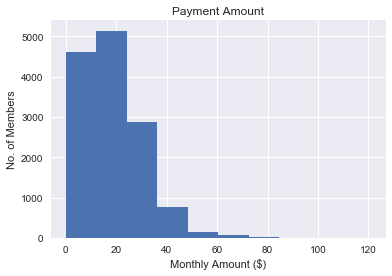

In [22]:
plt.figure()
data_numerical['AMOUNT'].hist()
plt.title('Payment Amount')
plt.xlabel('Monthly Amount ($)')
plt.ylabel('No. of Members')

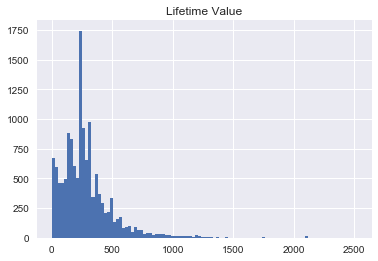

In [21]:
plt.figure()
data_numerical['VALUE'].hist(bins=100)
plt.title('Lifetime Value')
plt.xlabel('Value over length of membership ($)')
plt.ylabel('No. of Members')

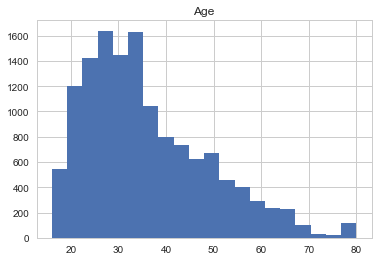

In [159]:
plt.figure()
data_numerical['AGE'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('No. of Members')

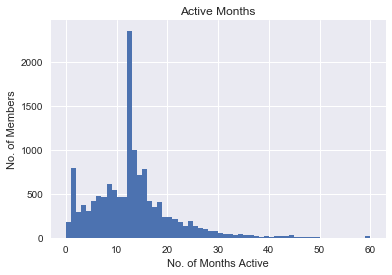

In [23]:
plt.figure()
data_numerical['ACTIVE_MONTHS'].hist(bins=60)
plt.title('Active Months')
plt.xlabel('No. of Months Active')
plt.ylabel('No. of Members')

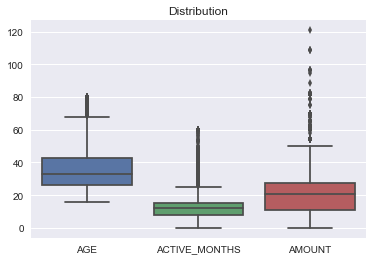

In [24]:
feats = ['AGE','ACTIVE_MONTHS','AMOUNT']
sns.boxplot(data=data_numerical[feats])
plt.title('Distribution')

** Let's explore the data for correlation between features. Keeping in mind that the created features (ie. Lifetime Value) will have strong correlation with the features from which they were made**

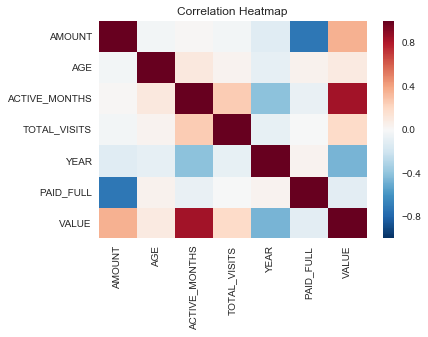

In [25]:
sns.heatmap(data_numerical.drop(['SEX'],axis=1).corr())
plt.title('Correlation Heatmap')
#plt.savefig('correlation_heatmap.png', bbox_inches='tight')

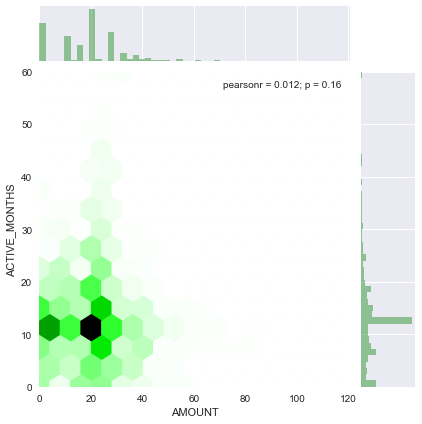

In [29]:
sns.jointplot(x='AMOUNT', y='ACTIVE_MONTHS', data=data_numerical, kind='hex', gridsize=15, color='green')
#plt.savefig('Active_Amount.png', bbox_inches='tight')

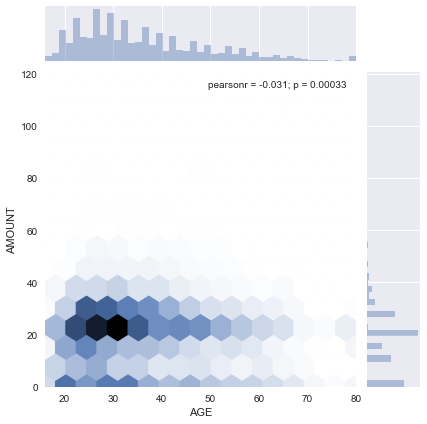

In [30]:
sns.jointplot(x='AGE', y='AMOUNT', data=data_numerical, kind='hex', gridsize=15)

** Monthly visits **

In [32]:
visit_value = data_numerical.copy()
visit_value.head(3)

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,SEX,YEAR,PAID_FULL,VALUE
0,0.0,80,5.0,0,F,2015,1,104.166667
8,35.0,37,60.0,5,F,2006,0,2100.000000
10,37.0,65,60.0,3,F,2006,0,2220.000000


In [33]:
from math import ceil
def monthly_visits(tot_visits,months):
    if months == 0:
        visits = 0
    else:
        visits = ceil(tot_visits/months)
    return visits

In [34]:
visit_value['MONTHLY_VISITS'] = visit_value.apply(lambda row: 
                                                  monthly_visits(row['TOTAL_VISITS'],
                                                                 row['ACTIVE_MONTHS']),axis=1)
visit_value.head(3)

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,SEX,YEAR,PAID_FULL,VALUE,MONTHLY_VISITS
0,0.0,80,5.0,0,F,2015,1,104.166667,0
8,35.0,37,60.0,5,F,2006,0,2100.000000,1
10,37.0,65,60.0,3,F,2006,0,2220.000000,1


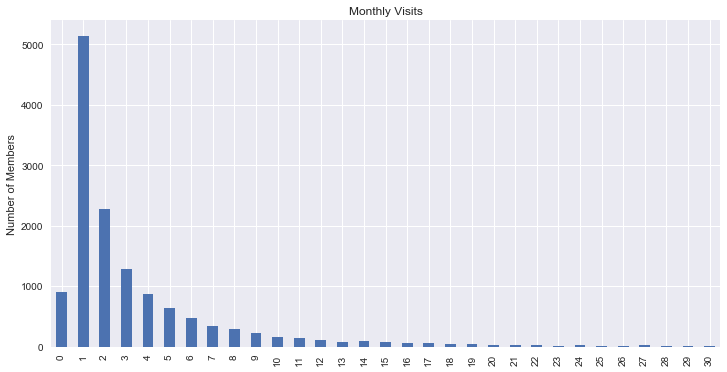

In [35]:
visit_value[visit_value['MONTHLY_VISITS']<31]['MONTHLY_VISITS'].value_counts().sort_index().plot.bar(figsize=(12, 6))
plt.title('Monthly Visits')
plt.ylabel('Number of Members')
#plt.savefig('Monthly_Visits.png', bbox_inches='tight')

## Quick Classification Trial

Rough mock-up of a scikit pipeline to assess whether data can accurately be classified

Also try to perform regression later if classification is successful

**1. Predicting Two Year Customers (Since most cancel after 1-year**

In [45]:
#data_numerical['TWO_YEAR'] = data_numerical['ACTIVE_MONTHS'] >= 24
#cat_feats = ['SEX','TWO_YEAR']
#data_numerical = pd.get_dummies(data_numerical,columns=cat_feats)
#data_numerical.drop(['TWO_YEAR'],inplace=True, axis=1)
#data_numerical.drop(['SEX_U'],inplace=True, axis=1)
data_numerical.head()

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,YEAR,PAID_FULL,VALUE,SEX_M,TWO_YEAR_True
0,0.0,80,5.0,0,2015,1,104.166667,0,0
8,35.0,37,60.0,5,2006,0,2100.000000,0,1
10,37.0,65,60.0,3,2006,0,2220.000000,0,1
13,35.0,32,28.0,31,2006,0,980.000000,1,1
15,35.0,52,60.0,61,2006,0,2100.000000,0,1


In [55]:
X = data_numerical.drop(['TWO_YEAR_True', 'ACTIVE_MONTHS',
                         'YEAR','VALUE','TOTAL_VISITS'], axis=1)
y = data_numerical['TWO_YEAR_True']

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [58]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [59]:
print('classification report')
print(classification_report(y_test, predictions))
print('confusion matrix')
print(confusion_matrix(y_test,predictions))

classification report
             precision    recall  f1-score   support

          0       0.92      0.98      0.94      3106
          1       0.27      0.09      0.14       306

avg / total       0.86      0.90      0.87      3412

confusion matrix
[[3031   75]
 [ 278   28]]


Random Forest Classifier

In [60]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('classification report')
print(classification_report(y_test, predictions))
print('confusion matrix')
print(confusion_matrix(y_test,predictions))

classification report
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      3106
          1       0.31      0.10      0.15       306

avg / total       0.86      0.90      0.88      3412

confusion matrix
[[3039   67]
 [ 276   30]]


**2. Predicting Membership past one year**

In [61]:
data_numerical.rename(columns={'TWO_YEAR_True': 'ONE_YEAR'}, inplace=True)
data_numerical.head(1)

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,YEAR,PAID_FULL,VALUE,SEX_M,ONE_YEAR
0,0.0,80,5.0,0,2015,1,104.166667,0,0


In [62]:
data_numerical['ONE_YEAR'] = data_numerical['ACTIVE_MONTHS'] > 12
data_numerical.head(3)

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,YEAR,PAID_FULL,VALUE,SEX_M,ONE_YEAR
0,0.0,80,5.0,0,2015,1,104.166667,0,False
8,35.0,37,60.0,5,2006,0,2100.000000,0,True
10,37.0,65,60.0,3,2006,0,2220.000000,0,True


In [63]:
cat_feats = ['ONE_YEAR']
data_numerical = pd.get_dummies(data_numerical,columns=cat_feats, drop_first=True)
data_numerical.head()

,AMOUNT,AGE,ACTIVE_MONTHS,TOTAL_VISITS,YEAR,PAID_FULL,VALUE,SEX_M,ONE_YEAR_True
0,0.0,80,5.0,0,2015,1,104.166667,0,0
8,35.0,37,60.0,5,2006,0,2100.000000,0,1
10,37.0,65,60.0,3,2006,0,2220.000000,0,1
13,35.0,32,28.0,31,2006,0,980.000000,1,1
15,35.0,52,60.0,61,2006,0,2100.000000,0,1


In [64]:
X = data_numerical.drop(['ONE_YEAR_True', 'ACTIVE_MONTHS',
                         'YEAR','VALUE','TOTAL_VISITS'], axis=1)
y = data_numerical['ONE_YEAR_True']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('classification report')
print(classification_report(y_test, predictions))
print('confusion matrix')
print(confusion_matrix(y_test,predictions))

classification report
             precision    recall  f1-score   support

          0       0.62      0.73      0.67      1920
          1       0.55      0.43      0.48      1492

avg / total       0.59      0.60      0.59      3412

confusion matrix
[[1403  517]
 [ 854  638]]


In [66]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('classification report')
print(classification_report(y_test, predictions))
print('confusion matrix')
print(confusion_matrix(y_test,predictions))

classification report
             precision    recall  f1-score   support

          0       0.63      0.68      0.66      1920
          1       0.55      0.49      0.52      1492

avg / total       0.60      0.60      0.60      3412

confusion matrix
[[1308  612]
 [ 756  736]]


**Conclusions** 
+ The current data available is not suited for predictive modeling. Comprehensive data collection methods will be suggested for the future. 
+ The data should also be explored in more depth to identify important trends and behavior, to better serve customers and develop marketing strategies to improve member retention.

**Original Questions**
1. Correlation between payment amount and length of membership 
2. Male vs Female lifetime value
3. Monthly visits & value

**New Ideas**
1. Year-by-year (start date)
2. Remove Paid-in-full members 